In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
columns = {0:'datetime',1:'open',2:'high',3:'low',4:'close',5:'volume'}

btc_raw = pd.read_csv("btcusd.csv", header=None)
eth_raw = pd.read_csv("ethusd60.csv", header=None)

In [3]:
def make_df(raw_df):
    df = raw_df.loc[:,:5]
    df.rename(columns=columns, inplace=True)
    df = df[["datetime", "close"]]
    
    df["timestamp"] = df["datetime"].apply(lambda x: dt.datetime.fromtimestamp(x))
    df = df.drop(columns="datetime")
    df.set_index("timestamp", inplace=True)
    df.index=pd.to_datetime(df.index)
    return df

In [4]:
btc = make_df(btc_raw)
eth = make_df(eth_raw)
btc.rename(columns={"close":"btc"}, inplace=True)
eth.rename(columns={"close":"eth"}, inplace=True)
hist_df = btc.merge(eth, how="inner", on="timestamp")
hist_df.index.dtype

dtype('<M8[ns]')

In [5]:
current_df = pd.read_csv("crypto_current.csv", parse_dates=True, infer_datetime_format=True, index_col="timestamp")
current_df.index.dtype

dtype('<M8[ns]')

In [6]:
num_ticks = 60
tickers = ["btc","eth"]
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(45978, 120)

In [7]:
hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_Buy"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=24).shift(-24).apply(lambda x : 1 if x >= 0.01 else 0)
    hist_pct_returns_df_list.append(returns_df)
hist_pct_returns_df_list[0]["btc_Buy"].sum()

16863

In [8]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [9]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(45918, 122)

In [10]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)

In [11]:
y_start = len(tickers)*num_ticks

In [13]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [14]:
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)

In [15]:
brf_models = []
brf_confusion = []
brf_classification = []
target_names = ["Not Buy", "Buy"]
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y[i],random_state=1,stratify=y[i])
    model.fit(X_train,y_train)
    brf_models.append(model)
    predicted = model.predict(X_test)
    brf_confusion.append(confusion_matrix(y_test, predicted))
    brf_classification.append(classification_report(y_test, predicted, target_names=target_names))
    print("--------------------------------------")
    print(ticker)
    print(f"Training Data Score: {model.score(X_train, y_train)}")
    print(f"Testing Data Score: {model.score(X_test, y_test)}")
    print(brf_confusion[i])
    print(brf_classification[i])

--------------------------------------
btc
Training Data Score: 0.9995063592543121
Testing Data Score: 0.5645470383275262
[[3981 3285]
 [1714 2500]]
              precision    recall  f1-score   support

     Not Buy       0.70      0.55      0.61      7266
         Buy       0.43      0.59      0.50      4214

    accuracy                           0.56     11480
   macro avg       0.57      0.57      0.56     11480
weighted avg       0.60      0.56      0.57     11480

--------------------------------------
eth
Training Data Score: 0.9999709623090772
Testing Data Score: 0.5475609756097561
[[3834 2999]
 [2195 2452]]
              precision    recall  f1-score   support

     Not Buy       0.64      0.56      0.60      6833
         Buy       0.45      0.53      0.49      4647

    accuracy                           0.55     11480
   macro avg       0.54      0.54      0.54     11480
weighted avg       0.56      0.55      0.55     11480



In [16]:
#Predict pct-change for each of the tickers over the month of June 2021
y_current_predicted = []
current_returns_df_list = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = brf_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)
    return_df = pd.DataFrame({"timestamp":current_pctchange_df.index, "buy_predicted": predicted})
    return_df = return_df.set_index("timestamp")
    return_df = return_df.merge(current_df[ticker], how="left", on="timestamp")
    print(ticker, return_df["buy_predicted"].sum())

    money = 10000
    num_shares = 0
    state = 0
    buy_index = 0
    money_list=[]

    for i in range(0,len(return_df)):
        if state == 1 and i == buy_index + 16:
            #sell
            price = return_df.iloc[i,1]
            money = num_shares * price
            state = 0
            print(f"sell {ticker}", i ,price)

        if return_df.iloc[i,0] == 1 and state == 0 and i < len(return_df) - 16:
            #buy
            price = return_df.iloc[i,1]
            num_shares = money / price
            buy_index = i
            state = 1
            print(f"buy {ticker}", i, price)

        if return_df.iloc[i,0] == 1 and state == 1 and i < len(return_df) - 16:
            buy_index = i

        if state == 0 :
            money_list.append(money)
        else:
            price = return_df.iloc[i,1]
            money_list.append(num_shares*price)
    
    return_df["ROI"] = money_list

    current_returns_df_list.append(return_df)

btc 584
buy btc 0 36883.3
sell btc 659 33501.5
eth 532
buy eth 0 2645.39
sell eth 659 2118.83


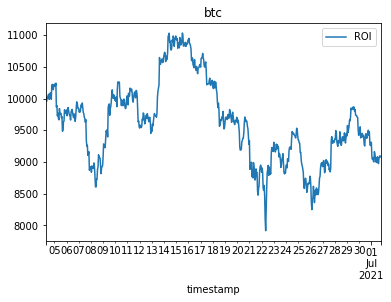

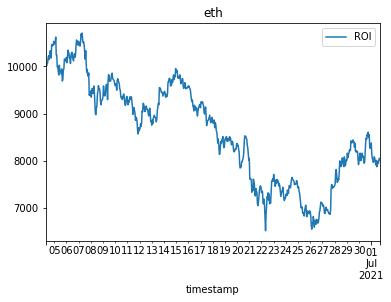

In [17]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    current_returns_df_list[i].plot(y="ROI", title=ticker)

In [18]:
starting_amount = 10000*len(tickers)
ending_amount = 0
for i in range(0,len(tickers)):
    ending_amount += current_returns_df_list[i].iloc[-1,-1]
ending_amount

17092.62651859687

In [19]:
print("TOTAL BUY SIGNALS------------")
for i in range(0,len(tickers)):
    print(f"{tickers[i]}: {current_returns_df_list[i]['buy_predicted'].sum()}")

TOTAL BUY SIGNALS------------
btc: 584
eth: 532


In [20]:
summary_df = current_returns_df_list[0].copy()
summary_df = pd.DataFrame(summary_df["ROI"])
summary_df = summary_df.rename(columns={"ROI": f"IMB_{tickers[0]}"})
for i in range(1,len(tickers)):
    temp_df = current_returns_df_list[i].copy()
    temp_df = pd.DataFrame(temp_df["ROI"])
    temp_df = temp_df.rename(columns={"ROI": f"IMB_{tickers[i]}"})
    summary_df = pd.concat([summary_df, temp_df], axis=1)
summary_df.to_csv("crypto_imb_roi.csv")